In [41]:
%matplotlib inline
from urllib.request import urlopen
from bs4 import BeautifulSoup
from bs4 import Comment
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
import scipy.stats as st
import re
from openpyxl import load_workbook
import seaborn as sns
import timeit
import sqlite3
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers

In [42]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [43]:
def remove_multicollinearity(df_train):
  remove_cols = ['FG', 'team_ORtg', 'ORB%', 'DRB%', 'STL%', 'BLK%', 'opp_diff_eFGp', 'FT','USG%', '3P', 'AST%', 'TS%']
  df_train = df_train.drop(columns=remove_cols)
  return df_train

In [44]:
def fit_transform_to_normal(df_train):

    powers = [1, 1/2, 1/3, 1/4, 1/5]
    values = []
    for col in df_train.columns[2:]:
        skew = []
        for power in powers:
            x = df_train[col].apply(lambda x: np.power(x, power))
            x = st.skew(x)
            if x < 5 and x > -5: # get rid of case when x is nan
                skew.append(x)
            else:
                skew.append(999)
        ind = np.argmin(np.abs(skew))
        power = powers[ind]
        df_train[col] = df_train[col].apply(lambda x: np.power(x, power))
        values.append(power)
    return df_train, values

In [45]:
def transform_to_normal(df_test, power_values):
  for i, col in enumerate(df_test.columns[2:]):
    df_test[col] = df_test[col].apply(lambda x: np.power(x, power_values[i]))
  return df_test

In [46]:
def remove_irrelevant_features(df_train, target):
    possible_targets = ['target_PTS', 'target_TRB', 'target_AST']
    for i, t in enumerate(possible_targets):
        if t == target:
            del possible_targets[i]
    remove_cols = ['player_id', 'team_id', 'opp_id', 'game_id', 'season_id', 'date'] + possible_targets
    df_train.drop(columns=remove_cols, inplace=True)
    return df_train

# Main Code

In [47]:
target = 'target_PTS'

In [48]:
df_train = pd.read_csv('gdrive/MyDrive/Colab Notebooks/NBA_predictions/train_data/n_seasons5_avgGames5_playoffsTrue_skipDays18_minmin25.csv')
df_train.drop(columns=['Unnamed: 0'], inplace=True)
df_train.head()

,player_id,team_id,opp_id,game_id,season_id,date,home,day_of_week,start_time,percent_season,team_avg_pts,opp_avg_pts,team_inactive_salary,opp_inactive_salary,min,FG,FGA,3P,3PA,FT,FTA,ORB,DRB,AST,STL,BLK,TOV,PF,PTS,+/-,TS%,eFG%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,ORtg,DRtg,BPM,team_Pace,team_eFGp,team_TOVp,team_ORBp,team_FTvFGA,team_ORtg,opp_diff_Pace,opp_diff_eFGp,opp_diff_TOVp,opp_diff_ORBp,opp_diff_FTvFGA,opp_diff_ORtg,target_PTS,target_TRB,target_AST
0,7,23,8,5208,5,2021-01-09,1,5,0.250000,0.131944,122.2,116.4,0.718700,0.029874,25.411,4.579,7.496,0.023,0.064,2.797,5.068,3.053,7.271,1.053,0.624,1.222,1.962,3.060,11.977,0.293,0.621,0.620,0.012,0.749,13.171,30.121,21.676,6.178,1.190,4.069,18.561,19.457,113.211,104.000,-0.225,99.153,0.525,13.307,23.962,0.215,109.870,-8.224,0.0374,1.181,5.348,-0.0238,6.715,11,11,2
1,436,23,8,5208,5,2021-01-09,1,5,0.250000,0.131944,122.2,116.4,0.718700,0.029874,26.230,2.972,7.305,1.881,4.900,0.526,0.681,0.693,2.803,1.512,1.011,0.756,0.986,1.978,8.352,4.047,0.539,0.523,0.678,0.107,2.945,11.705,7.394,7.944,1.961,2.477,11.247,14.477,105.463,107.028,0.340,99.153,0.525,13.307,23.962,0.215,109.870,-8.224,0.0374,1.181,5.348,-0.0238,6.715,11,3,5
2,464,4,1,5209,5,2021-01-09,1,5,0.583333,0.131944,105.2,109.6,0.159291,0.328358,31.341,6.030,12.728,1.616,4.289,3.319,3.871,0.750,4.599,3.530,0.905,0.328,1.754,1.694,16.996,3.435,0.566,0.517,0.350,0.304,2.631,15.747,9.299,18.027,1.452,0.942,11.379,22.731,112.284,108.978,2.463,96.748,0.508,11.083,21.813,0.217,109.799,0.970,-0.0442,-0.292,-1.065,0.0300,-5.471,13,1,3
3,649,4,1,5209,5,2021-01-09,1,5,0.583333,0.131944,105.2,109.6,0.159291,0.328358,25.459,3.831,8.688,1.162,3.487,1.104,1.390,1.071,3.747,1.442,0.656,0.701,1.058,1.701,9.929,-3.292,0.524,0.498,0.409,0.188,4.394,16.544,10.279,8.475,1.246,2.597,10.128,17.475,103.994,113.123,-2.362,96.748,0.508,11.083,21.813,0.217,109.799,0.970,-0.0442,-0.292,-1.065,0.0300,-5.471,2,3,1
4,651,4,1,5209,5,2021-01-09,1,5,0.583333,0.131944,105.2,109.6,0.159291,0.328358,26.929,4.008,10.949,2.322,6.585,2.051,2.525,0.492,2.102,5.508,0.822,0.144,1.856,1.517,12.390,-2.136,0.473,0.437,0.586,0.224,1.680,8.133,4.814,29.707,1.517,0.409,12.739,21.384,103.051,117.212,-1.850,96.748,0.508,11.083,21.813,0.217,109.799,0.970,-0.0442,-0.292,-1.065,0.0300,-5.471,9,5,7


In [49]:
# try only making predictions on players scoring at least 12 points
df_train = df_train[df_train['target_PTS'] >= 12]

# filter out 2021 playoffs to use as a test set since I have over/under predictions for that
df_train['date'] = pd.to_datetime(df_train['date'])
df_train = df_train[df_train['date'] < pd.to_datetime('2021-05-18')]

In [50]:
df_train = remove_multicollinearity(df_train)
df_train = remove_irrelevant_features(df_train, target)

In [51]:
# create train / test / valid split 
df_train, df_valid = train_test_split(df_train, test_size=0.2)

# convert back to data frame
df_train = pd.DataFrame(df_train, columns=df_train.columns)
df_valid = pd.DataFrame(df_valid, columns=df_train.columns)

In [52]:
df_train, power_values = fit_transform_to_normal(df_train)
df_valid = transform_to_normal(df_valid, power_values)

reverse_target_power = 1 / power_values[-1] # need to use this to convert predictions to actual target

In [53]:
# convert day_of_week to categorical
df_train[['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']] = pd.get_dummies(df_train['day_of_week'])
df_train.drop(columns='day_of_week', inplace=True)
df_valid[['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']] = pd.get_dummies(df_valid['day_of_week'])
df_valid.drop(columns='day_of_week', inplace=True)

In [54]:
# separate features from target
X_train = df_train.drop(columns=target)
y_train = df_train[target]
X_valid = df_valid.drop(columns=target)
y_valid = df_valid[target]

In [55]:
scale = StandardScaler()
scale_cols = ['start_time', 'percent_season', 'team_avg_pts', 'opp_avg_pts', 'team_inactive_salary', 
              'opp_inactive_salary', 'min', 'FGA', '3PA', 'FTA', 'ORB', 'DRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 
              'PTS', '+/-', 'eFG%', '3PAr', 'FTr', 'TRB%', 'TOV%', 'ORtg', 'DRtg', 'BPM', 'team_Pace', 'team_eFGp', 
              'team_TOVp', 'team_ORBp', 'team_FTvFGA', 'opp_diff_Pace', 'opp_diff_TOVp', 'opp_diff_ORBp', 
              'opp_diff_FTvFGA', 'opp_diff_ORtg']

transformer = ColumnTransformer([('scale', scale, scale_cols)], remainder='passthrough')

X_train = transformer.fit_transform(X_train)
X_valid = transformer.transform(X_valid)

y_train = y_train.values
y_valid = y_valid.values

# Model Development

In [56]:
def nll(y_true, y_pred):
  return - y_pred.log_prob(y_true)

In [57]:
input_shape = (X_train.shape[1],)

reg = tf.keras.regularizers.L1(0.1)

model = Sequential([
                    Dense(16, activation='elu', kernel_regularizer=reg, input_shape=input_shape),
                    BatchNormalization(),
                    Dense(8, activation='elu', kernel_regularizer=reg),
                    BatchNormalization(),
                    Dense(4, activation='elu', kernel_regularizer=reg),
                    BatchNormalization(),
                    Dense(tfpl.IndependentNormal.params_size(1)),
                    tfpl.IndependentNormal(event_shape=(1))
])
model.compile(loss=nll, optimizer='adam', metrics='mse')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 16)                736       
_________________________________________________________________
batch_normalization_3 (Batch (None, 16)                64        
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 136       
_________________________________________________________________
batch_normalization_4 (Batch (None, 8)                 32        
_________________________________________________________________
dense_6 (Dense)              (None, 4)                 36        
_________________________________________________________________
batch_normalization_5 (Batch (None, 4)                 16        
_________________________________________________________________
dense_7 (Dense)              (None, 2)                

In [58]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)

history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_valid, y_valid), callbacks=[early_stop])

Epoch 1/30
735/735 [==============================] - 4s 5ms/step - loss: 15.6140 - mse: 7.5453 - val_loss: 9.9759 - val_mse: 5.0401
Epoch 2/30
735/735 [==============================] - 3s 4ms/step - loss: 6.5368 - mse: 6.8417 - val_loss: 3.3909 - val_mse: 2.7744
Epoch 3/30
735/735 [==============================] - 3s 4ms/step - loss: 2.2777 - mse: 5.4102 - val_loss: 0.9942 - val_mse: 2.9261
Epoch 4/30
735/735 [==============================] - 3s 4ms/step - loss: 0.7256 - mse: 4.1968 - val_loss: 0.5189 - val_mse: 3.1659
Epoch 5/30
735/735 [==============================] - 3s 4ms/step - loss: 0.0055 - mse: 1.6043 - val_loss: 0.3781 - val_mse: 2.0028
Epoch 6/30
735/735 [==============================] - 3s 4ms/step - loss: -0.3694 - mse: 0.3733 - val_loss: -0.0946 - val_mse: 0.1326
Epoch 7/30
735/735 [==============================] - 3s 4ms/step - loss: -0.6379 - mse: 0.0346 - val_loss: -0.7148 - val_mse: 0.0228
Epoch 8/30
735/735 [==============================] - 3s 4ms/step - los

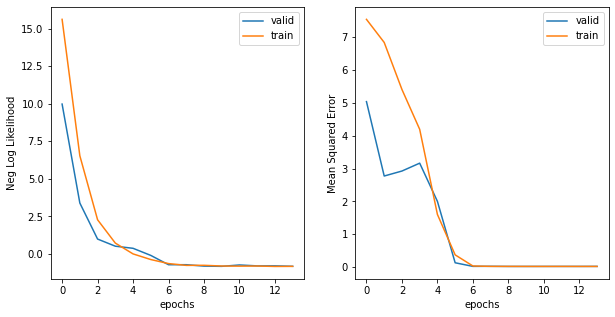

In [59]:
fig, [ax1, ax2] = plt.subplots(1,2, figsize=(10,5))

ax1.plot(history.history['val_loss'], label='valid')
ax1.plot(history.history['loss'], label='train')
ax1.set_xlabel('epochs')
ax1.set_ylabel('Neg Log Likelihood')
ax1.legend()

ax2.plot(history.history['val_mse'], label='valid')
ax2.plot(history.history['mse'], label='train')
ax2.set_xlabel('epochs')
ax2.set_ylabel('Mean Squared Error')
_ = ax2.legend()

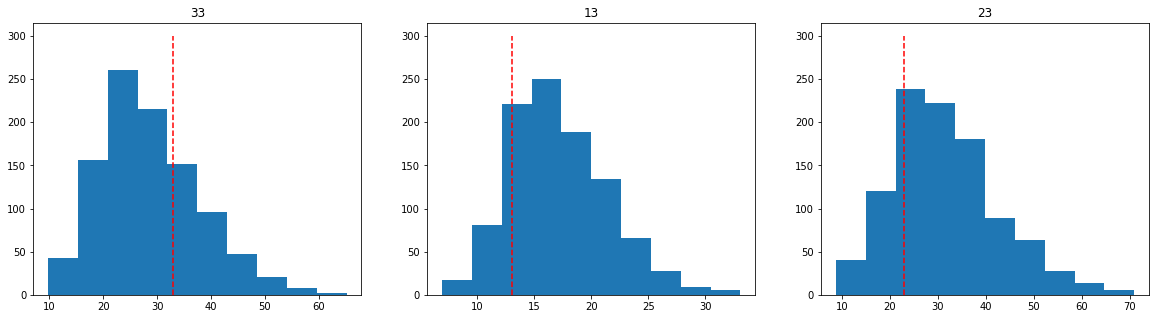

In [60]:
indices = np.random.choice(len(X_valid), size=3, replace=False)

fig, axs = plt.subplots(1, 3, figsize=(20,5))

for i, ind in enumerate(indices):
  y_model = model(X_valid[ind, :][np.newaxis, :])
  y_samples = y_model.sample(1000)[:,0,0]
  y_samples = np.power(y_samples, reverse_target_power)
  y_actual = np.power(y_valid[ind], reverse_target_power)
  axs[i].hist(y_samples)
  axs[i].vlines(y_actual,0, 300, color='red', linestyles='dashed')
  _ = axs[i].set_title(round(y_actual))

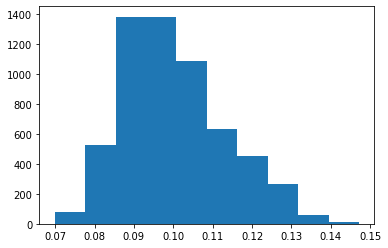

In [61]:
y_model = model(X_valid)
y_sample = tf.reduce_mean(y_model.sample(3), axis=0)[:,0]
y_hat = y_model.mean()
y_sd = y_model.stddev()

_ = plt.hist(y_sd[:,0])

In [62]:
#model.save('model_to_test_2021_playoffs.h5')

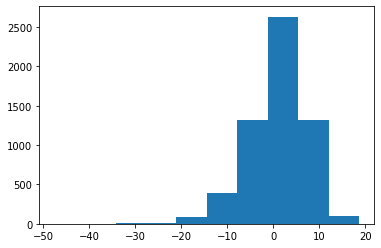

In [83]:
model_valid = model(X_valid)
model_sample = model_valid.sample(1000)[..., 0].numpy()

# convert to actual points scored
model_sample = np.power(model_sample, reverse_target_power)

model_pred = tf.reduce_mean(model_sample, axis=0)

model_diff = model_pred - np.power(y_valid, reverse_target_power)

_ = plt.hist(model_diff)

# Test on 2021 playoff data

In [112]:
#model = tf.keras.models.load_model('model_to_test_2021_playoffs.h5', compile=False)
#model.compile(loss=nll, optimizer='adam', metrics='mse')
#model.summary()

In [113]:
df_test = pd.read_csv('gdrive/MyDrive/Colab Notebooks/NBA_predictions/test_data/test_n_seasons5_avgGames5_playoffsTrue_skipDays18_minmin25.csv')
df_test.drop(columns=['Unnamed: 0'], inplace=True)
df_test = remove_multicollinearity(df_test)
df_test = remove_irrelevant_features(df_test, target)

df = df_test[['target_PTS', 'O/U']]

df_test_OU = df_test['O/U'].to_numpy()
df_test = df_test.drop(columns='O/U')

def transform_test_to_normal(df_test, power_values):
  for i, col in enumerate(df_test.columns[2:]):
    df_test[col] = df_test[col].apply(lambda x: np.power(x, power_values[i]))
  return df_test

df_test = transform_test_to_normal(df_test, power_values)
df_test[['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']] = pd.get_dummies(df_test['day_of_week'])
df_test.drop(columns='day_of_week', inplace=True)
X_test = df_test.drop(columns=target)
y_test = df_test[target]
X_test = transformer.transform(X_test)
y_test = y_test.values

In [114]:
model_test = model(X_test)
model_sample = model_test.sample(1000)[..., 0].numpy()

# conver to actual points scored
model_sample = np.power(model_sample, reverse_target_power)

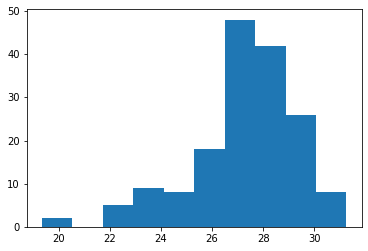

In [115]:
_ = plt.hist(tf.reduce_mean(model_sample, axis=0))

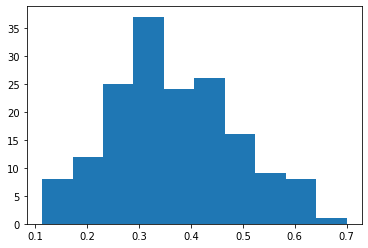

In [116]:
y_compare = model_sample > df_test_OU.reshape(1, -1)
y_compare = y_compare.sum(axis=0) / len(y_compare)

df['prob'] = y_compare

_ = plt.hist(y_compare)

In [117]:
def guess_probability_of_winning(prob):
  if prob > 0.5:
    wager = 1
  else:
    wager = 0
    prob = 1 - prob
  return pd.Series([prob, wager])

df[['prob', 'wager']] = df['prob'].apply(guess_probability_of_winning)

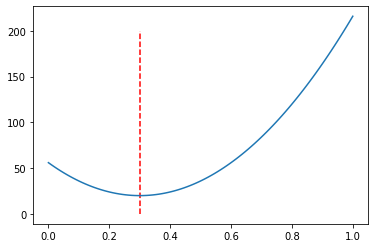

In [118]:
x = np.linspace(0,1,100)
y = 20 + 400 * (x - 0.3) ** 2
plt.plot(x,y)
plt.vlines(0.3 ,0, 200, color='red', linestyles='dashed')

In [119]:
df['money'] = pd.Series(np.zeros(len(df)))

for i in range(int(len(df)/2)):
  prob1 = df['prob'][2*i]
  prob2 = df['prob'][2*i+1]
  prob = prob1 * prob2
  if prob < 0.5:
    money = 0
  else:
    money = 20 + 400 * (prob - 0.5) ** 2
  df['money'][2*i] = money
  df['money'][2*i+1] = money

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [120]:
def is_correct(row):
  actual_pts = row[0]
  OU = row[1]
  wager = row[3]
  if wager == 1:
    if actual_pts > OU:
      return 1
    else:
      return 0
  else:
    if actual_pts < OU:
      return 1
    else:
      return 0

df['correct'] = df.apply(is_correct, axis=1)

In [121]:
df['winnings'] = pd.Series(np.zeros(len(df)))

for i in range(int(len(df)/2)):
  money = df['money'][2*i] 
  correct1 = df['correct'][2*i]
  correct2 = df['correct'][2*i+1]
  correct = correct1 + correct2
  if correct == 2:
    winnings = 2.6 * money
  else:
    winnings = -1 * money
  df['winnings'][2*i] = winnings
  df['winnings'][2*i+1] = winnings

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [122]:
money = [1000]
for i in range(int(len(df)/2)):
  winnings = df['winnings'][2*i]
  money.append(money[i] + winnings)

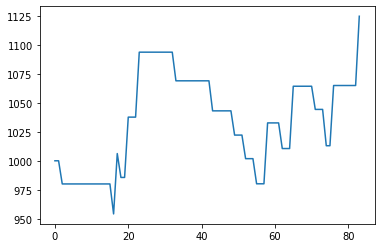

In [123]:
plt.plot(money)

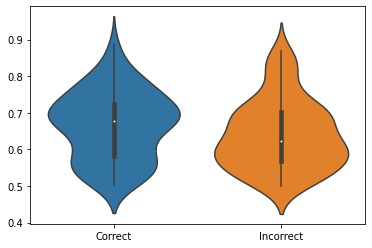

In [124]:
correct = df[df['correct'] == 1]
incorrect = df[df['correct'] == 0]

sns.violinplot(data=[correct['prob'], incorrect['prob']])
plt.gca().set_xticklabels(['Correct', 'Incorrect'])
plt.show()

In [125]:
df['correct'].mean()

0.5060240963855421